## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
import sys
sys.path.append("../figures")

from robust_what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST

In [5]:
from main import init
args = init(filename='../data/2019-06-12')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'what_offset_std': 5.0,
 'what_offset_max': 15}

## Affichge image MNIST 28x28

In [6]:
transform=transforms.Compose([
                               WhatShift(args, i_offset=None, j_offset=None),
                               WhatBackground(),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

In [7]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

In [8]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [9]:
data, label = next(iter(test_loader))

Text(0.5, 1.0, 'label : 7')

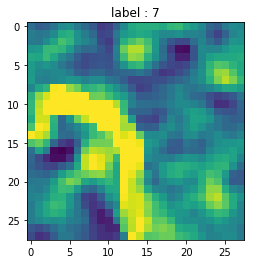

In [10]:
i = 3
plt.imshow(data[i,:,:].detach().numpy().reshape((28, 28)))
plt.title('label : '+str(label[i].item()))

## Affichage Image 128x128

In [11]:
import sys
sys.path.append("../figures")

from where_copie import RetinaFill, RetinaBackground, RetinaMask, RetinaWhiten 

In [34]:
i_offset = None
j_offset = None

In [70]:
from display import minmax

class WhereShift:
    def __init__(self, args, i_offset=None, j_offset=None, radius=None, theta=None, baseline=0., keep_label = False):
        self.args = args
        self.i_offset = i_offset
        self.j_offset = j_offset
        self.radius = radius
        self.theta = theta
        self.baseline = baseline
        self.keep_label = keep_label

    def __call__(self, data):
        #sample = np.array(sample)
        
        sample = data[0]
        seed = data[1]
        if self.keep_label:
            label = data[2]
        
        #print(index)
        np.random.seed(seed)
        
        if self.i_offset is not None:
            i_offset = self.i_offset
            if self.j_offset is None:
                #j_offset_f = np.random.randn() * self.args.offset_std
                #j_offset_f = minmax(j_offset_f, self.args.offset_max)
                #j_offset = int(j_offset_f)
                j_offset = np.random.randint( - self.args.offset_max, self.args.offset_max)
            else:
                j_offset = int(self.j_offset)
        else: 
            if self.j_offset is not None:
                j_offset = int(self.j_offset)
                #i_offset_f = np.random.randn() * self.args.offset_std
                #i_offset_f = minmax(i_offset_f, self.args.offset_max)
                #i_offset = int(i_offset_f)
                i_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
            else: #self.i_offset is None and self.j_offset is None
                i_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
                j_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
                """
                if self.theta is None:
                    theta = np.random.rand() * 2 * np.pi
                    #print(theta)
                else:
                    theta = self.theta
                if self.radius is None:
                    radius_f = np.abs(np.random.randn()) * self.args.offset_std
                    radius = minmax(radius_f, self.args.offset_max)
                    #print(radius)
                else:
                    radius = self.radius
                i_offset = int(radius * np.cos(theta))
                j_offset = int(radius * np.sin(theta))
                """
                
        #print("i_offset = ", i_offset)
        #print("j_offset = ", j_offset)
                
        N_pic = sample.shape[0]
        fullfield = np.ones((N_pic, N_pic)) * self.baseline
        i_binf_patch = max(0, -i_offset)
        i_bsup_patch = min(N_pic, N_pic - i_offset)
        j_binf_patch = max(0, -j_offset)
        j_bsup_patch = min(N_pic, N_pic - j_offset)
        patch = sample[i_binf_patch:i_bsup_patch,
                       j_binf_patch:j_bsup_patch]

        i_binf_data = max(0, i_offset)
        i_bsup_data = min(N_pic, N_pic + i_offset)
        j_binf_data = max(0, j_offset)
        j_bsup_data = min(N_pic, N_pic + j_offset)
        fullfield[i_binf_data:i_bsup_data,
                  j_binf_data:j_bsup_data] = patch
        if self.keep_label:
            return fullfield, label, i_offset, j_offset
        else:
            return fullfield #.astype('B')

In [71]:
transform=transforms.Compose([
                               RetinaFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground( contrast=args.contrast,
                                                 noise=args.noise,
                                                 sf_0=args.sf_0,
                                                 B_sf=args.B_sf),
                               RetinaMask(N_pic=args.N_pic),
                               RetinaWhiten(N_pic=args.N_pic),
                               #RetinaTransform(retina.retina_transform_vector),
                               #Normalize()
                           ])

In [72]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        #target_transform = target_transform,
                        )

In [73]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [83]:
data3, label3 = next(iter(test_loader))

In [84]:
print(data3.shape)
label3.shape

torch.Size([100, 128, 128])


torch.Size([100])

shape torch.Size([100, 128, 128])


Text(0.5, 1.0, 'label : 8')

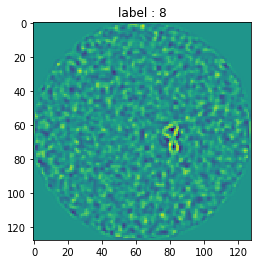

In [85]:
i=7
plt.imshow(data3[i])
print('shape',data3[:,:].shape)
plt.title('label : '+str(label3[i].item()))

In [ ]:

    def online_vectorization(self, pixel_fullfield):   # pixel_fullfield = image
        fullfield_dot_filters = np.zeros(self.N_theta * self.N_azimuth * self.N_eccentricity * self.N_phase)

        from LogGabor import LogGabor
        lg = LogGabor(pe=pe)
        lg.set_size((self.N_pic, self.N_pic))

        for i_theta in range(self.N_theta):
            for i_azimuth in range(self.N_azimuth):
                for i_eccentricity in range(self.N_eccentricity):
                    for i_phase in range(self.N_phase):
                        filter = self.local_filter(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=self.N_pic,
                                                  N_Y=self.N_pic)
                        indice = i_theta + i_azimuth + i_eccentricity + i_phase
                        fullfield_dot_filters[indice] = np.dot(np.ravel(filter), np.ravel(pixel_fullfield))

        return fullfield_dot_filters

In [ ]:
    def local_filter(self, i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                     N_X=128, N_Y=128):
                     #rho=1.41, ecc_max=.8,
                     #sf_0_max=0.45, sf_0_r=0.03,
                     #B_sf=.4, B_theta=np.pi / 12):

        # !!?? Magic numbers !!??
        ecc_max = .8 # self.args.ecc_max
        sf_0_r = 0.03 # self.args.sf_0_r
        B_theta = np.pi/self.N_theta/2 #self.args.B_theta
        B_sf = .4
        sf_0_max = 0.45
        
        ecc = ecc_max * (1 / self.args.rho) ** (self.N_eccentricity - i_eccentricity)
        r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
        # psi = i_azimuth * np.pi * 2 / N_azimuth
        psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / self.N_azimuth
        theta_ref = i_theta * np.pi / self.N_theta
        sf_0 = 0.5 * sf_0_r / ecc
        sf_0 = np.min((sf_0, sf_0_max))
        # TODO : find the good ref for this                print(sf_0)
        x = N_X / 2 + r * np.cos(psi)
        y = N_Y / 2 + r * np.sin(psi)
        params = {'sf_0': sf_0,
                  'B_sf': B_sf,
                  'theta': theta_ref + psi,
                  'B_theta': B_theta}
        phase = i_phase * np.pi / 2
        return lg.normalize(lg.invert(lg.loggabor(x, y, **params) * np.exp(-1j * phase))).ravel()
